<h1><center>Visualizing the global spread of COVID-19</center></h1>
<h3><center>Visualizing the spread of COVID-19 across the globe in the time period 22nd January to 23rd April</center></h3>

COVID-19 spread has become a global pandemic causing turmoil in the world.
The aim of this project is to visualize the affected countries and spread of COVID-19 in the time period - January 22, 2020 to April 5, 2020, to get a sense of the following questions :-
* How rapid was the spread of Corona-virus?
* Which countries were among the first to be infected?
<br>

The dataset used for this project, is the Kaggle dataset - <a href=https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#time_series_covid_19_deaths.csv>novel-corona-virus-2019</a><br><br>

The dataset contains multiple files, but for our goal, we will use the covid_19_data.csv file.<br>
This file contains Countrywise daily updates on the Confirmed, Deaths and Recoverd cases. A few columns :-<br>

    ObservationDate - Date on which data was recorded
    Country/Region - Country under observation
    Confirmed - No. of confirmed cases
    Deaths - No. of deaths
    Recovered - No. of Recovered
    

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.animation as animate
from IPython.display import HTML

Importing the dataset

In [33]:
df = pd.read_csv('/home/hp/Downloads/Covid-19 Datasets/covid_19_data.csv')
df.head(5)

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

Looking at the dataset, to make our job easier, we can rename a few columns for easier understanding and usage<br>

    ObservationDate: Date
    Country/Region: Country
    Province/State: State
   

In [34]:
df.rename(columns={'ObservationDate':'Date','Country/Region':'Country','Province/State':'State'},inplace=True)
df.head(5)

SNo        Date      State         Country      Last Update  Confirmed  \
0    1  01/22/2020      Anhui  Mainland China  1/22/2020 17:00        1.0   
1    2  01/22/2020    Beijing  Mainland China  1/22/2020 17:00       14.0   
2    3  01/22/2020  Chongqing  Mainland China  1/22/2020 17:00        6.0   
3    4  01/22/2020     Fujian  Mainland China  1/22/2020 17:00        1.0   
4    5  01/22/2020      Gansu  Mainland China  1/22/2020 17:00        0.0   

   Deaths  Recovered  
0     0.0        0.0  
1     0.0        0.0  
2     0.0        0.0  
3     0.0        0.0  
4     0.0        0.0

Now firstly, we will make a static choropleth using the `plotly` library, on the current number of confirmed cases i.e. as of April 23, 2020.<br>
To achieve this, let us first group the data based on `Country` and `Date`, as there are recorded observations on the same day for a country. This will give us per day Stats for a country sorted by date in descending.

In [62]:
grouped = df.groupby(['Country','Date'])
df_confirmed = grouped.sum().reset_index().sort_values(['Date'],ascending=False)
df_confirmed.tail(5)

Country        Date  SNo  Confirmed  Deaths  Recovered
5350  Mainland China  01/22/2020  535      547.0    17.0       28.0
3691       Hong Kong  01/22/2020   13        0.0     0.0        0.0
8762        Thailand  01/22/2020   37        2.0     0.0        0.0
8630          Taiwan  01/22/2020   29        1.0     0.0        0.0
4446           Japan  01/22/2020   36        2.0     0.0        0.0

We can observe that, there are Countries where there are 0 confirmed cases. We will have to remove these from our dataset

In [63]:
df_confirmed = df_confirmed[df_confirmed.Confirmed > 0]

Now let us observe the distrbution in the `Confirmed` cases, before we start with the choropleth map

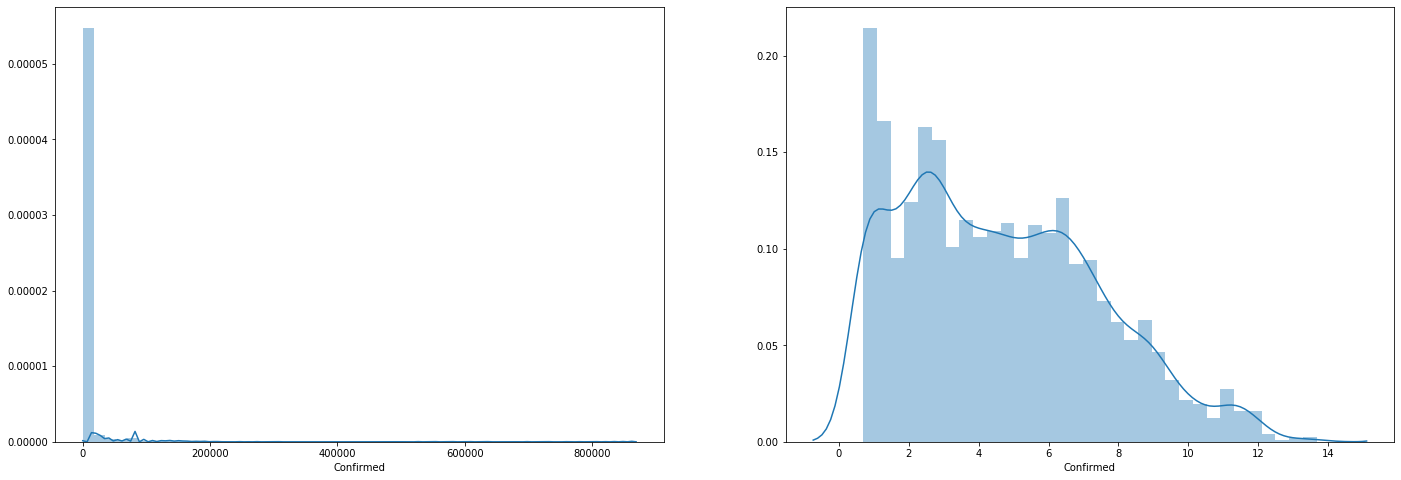

In [64]:
plt.subplots(figsize=(24,8))
plt.subplot(1,2,1)
sns.distplot(df_confirmed.Confirmed)
plt.subplot(1,2,2)
sns.distplot(np.log1p(df_confirmed.Confirmed))

Looking at the first subplot, we can see how skewed our data is, due to this, when we color code the `Confirmed` cases most data points lesser than say 20k (confirmed cases) would be of the same color but in reality they should be distinct.<br>
Thus taking the log `np.log10` of the data we can get better distictions in the Confirmed cases and visualize the spread of COVID-19 better.<br>
We will call this `Affected_Factor` as it better describes the spread of confirmed cases on a Logrithmic scale.

In [38]:
df_confirmed['Affected_Factor'] = np.log10(df_confirmed.Confirmed)

To get the most recent recorded data, we will drop all duplicates based on `Country` and hence, by default retaining the most current recorded data points.

In [39]:
df_confirmed.Country = df_confirmed.Country.str.strip()
df_confirmed.drop_duplicates(subset=['Country'],inplace=True)
df_confirmed.head(5)

Country        Date    SNo  Confirmed  Deaths  Recovered  \
9083      Turkey  04/23/2020  17856   101790.0  2491.0    18491.0   
6595      Norway  04/23/2020  17811     7401.0   194.0       32.0   
5194  Luxembourg  04/23/2020  17786     3665.0    83.0      728.0   
8947        Togo  04/23/2020  17853       88.0     6.0       59.0   
6759    Pakistan  04/23/2020  17813    11155.0   237.0     2527.0   

      Affected_Factor  
9083         5.007705  
6595         3.869290  
5194         3.564074  
8947         1.944483  
6759         4.047470

Finally plotting the choropleth, on the `Country` as location and `Confirmed` as data to be color-coded.

In [53]:
fig = go.Figure(     
    data= go.Choropleth(
        locations= df_confirmed.Country, #Spatial coordinates
        locationmode= 'country names', #Form of the spatial coordinates above
        z = df_confirmed['Confirmed'], #Values to be color coded
        colorscale = 'RdBu', 
        autocolorscale= False,
        reversescale= True,
        marker_line_color = 'darkgrey',
        marker_line_width = 0.1,
        colorbar_title= 'Confirmed Cases',
    )
)

fig.update_layout(
    title_text= 'Confirmed cases as of April 23, 2020',
    title_x= 0.5,
    geo= dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

Due to Github's inability to render the plot, the plot is saved as a `png` file as well

As discussed above, we can see that for countries having cases between 0 and 50k have almost the same hue of blue and hence this is misleading as to the degree of spread of COVID-19.<br>
To rectify this, we will use the new column we created above `Affected_Factor` for the plotting. 

In [60]:
fig = go.Figure(     
    data= go.Choropleth(
        locations= df_confirmed.Country, #Spatial coordinates
        locationmode= 'country names', #Form of the spatial coordinates above
        z = df_confirmed['Affected_Factor'], #Values to be color coded
        colorscale = 'RdBu', 
        autocolorscale= False,
        hovertext=df_confirmed.Confirmed,
        reversescale= True,
        marker_line_color = 'darkgrey',
        marker_line_width = 0.1,
        colorbar_title= 'Confirmed Cases (Log scale)',
    )
)

fig.update_layout(
    title_text= 'COVID-19 Spread as of April 23, 2020',
    title_x= 0.5,
    geo= dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

Due to Github's inability to render the plot, the plot is saved as a `png` file as well

This plot, can differentiate between countries and `Affected_Factor` acts as a good proxy to show degree of spread of COVID-19 in the world<br>


Next let us now try to animate the choropleth, to show the spread of COVID-19 in the time period - January 22, 2020 to April 5, 2020. <br>
We will use the same dataset, with similar modifications, this time we will group the data by `Date` and `Country` rather the other way round, as we want aggregated data on per-day basis. We will consider countries having cases more than 0 at any point in time. 

In [42]:
grouped = df[df.Confirmed > 0].groupby(['Date','Country'])

In [43]:
df_date_series = grouped.sum().reset_index()
df_date_series.Country = df_date_series.Country.str.strip()
df_date_series.head(5)

Date         Country  SNo  Confirmed  Deaths  Recovered
0  01/22/2020           Japan   36        2.0     0.0        0.0
1  01/22/2020           Macau   21        1.0     0.0        0.0
2  01/22/2020  Mainland China  373      547.0    17.0       28.0
3  01/22/2020     South Korea   38        1.0     0.0        0.0
4  01/22/2020          Taiwan   29        1.0     0.0        0.0

In a similar fashion we will calculate the proxy - `Affected_Factor` for the data points to better understand the spread (explained above).

In [44]:
df_date_series['Affected_Factor'] = np.log10(df_date_series.Confirmed)
df_date_series.head(5)

Date         Country  SNo  Confirmed  Deaths  Recovered  \
0  01/22/2020           Japan   36        2.0     0.0        0.0   
1  01/22/2020           Macau   21        1.0     0.0        0.0   
2  01/22/2020  Mainland China  373      547.0    17.0       28.0   
3  01/22/2020     South Korea   38        1.0     0.0        0.0   
4  01/22/2020          Taiwan   29        1.0     0.0        0.0   

   Affected_Factor  
0         0.301030  
1         0.000000  
2         2.737987  
3         0.000000  
4         0.000000

Using the `plotly.express` module, we can plot an animated choropleth map. Using `Country` as location, `Affected_Factor` as values to be color-coded and `Date` as the time-series upon which animation will be built.

In [61]:
fig = px.choropleth(
    df_date_series, #Dataframe
    locations= 'Country', #Spatial coordinates, can give Lat and Lon in separate params
    locationmode= 'country names', #Type of spatial coordinates
    color= 'Affected_Factor', #Values to be color coded
    hover_name= 'Country', #Text to be displayed in Bold upon hover
    hover_data= ['Confirmed','Recovered','Deaths'], #Extra text to be displayed in Hover tip
    animation_frame= 'Date', #Data for animation, time-series data
    color_continuous_scale= px.colors.sequential.RdBu_r
)

fig.update_layout(
    title_text = 'Global spread in Coronavirus over time (January 22 - April 23)',
    title_x = 0.5,
    geo= dict(
        showframe= False,
        showcoastlines= False,
        projection_type = 'equirectangular'
    )
)

Due to Github's inability to render the plot, the plot is saved as a `png` file as well

We observe the animation plot above showing the spread of COVID-19 in the time period chosen. Using `Affected_Factor` we can see the degree of spread over time distinctly.

In the choropleth maps above we can clearly see the general spread across the globe, but when it comes to head to head comparision, our `Affected Factor` doesnt really help. Keeping thi problem in mind, we are going to make a racing bar plot to get a head to head (in terms of country) idea of the spread.

First let us make a normal Bar plot for the 10 most affected countries as of April 5, 2020. This will give us a sense of how to style the racing bar plot later on.

Text(0, 0.5, 'Country')

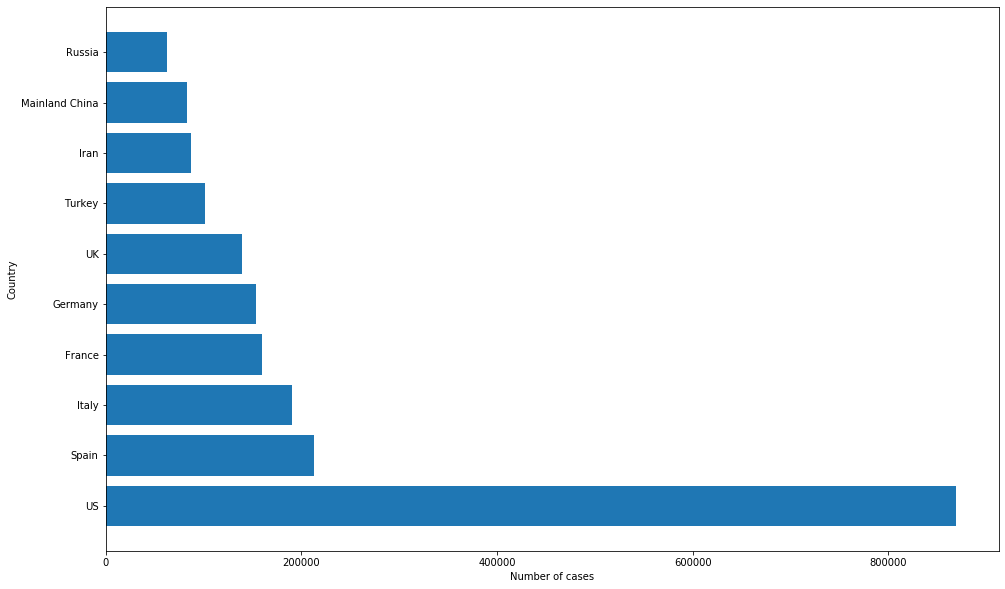

In [46]:
top_10_affected = df_confirmed.sort_values('Confirmed',ascending=False).iloc[:10]
top_10_affected = top_10_affected[['Country','Confirmed']].set_index('Country')
fig,ax = plt.subplots(figsize=(16,10))
ax.barh(top_10_affected.index,top_10_affected['Confirmed'])
plt.xlabel('Number of cases')
plt.ylabel('Country')

Looking at this, first thing is to have the widest bar on top rather than the bottom. Next thing is to assign colours to each country, make it look more vivid.

In [47]:
colors = dict(zip(
    top_10_affected.index,
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#aafbff', '#f7bb5f', '#eafb50','#009999','#fb6b19','#1fb1fb']
))
colors

{'US': '#adb0ff',
 'Spain': '#ffb3ff',
 'Italy': '#90d595',
 'France': '#e48381',
 'Germany': '#aafbff',
 'UK': '#f7bb5f',
 'Turkey': '#eafb50',
 'Iran': '#009999',
 'Mainland China': '#fb6b19',
 'Russia': '#1fb1fb'}

Text(0, 0.5, 'Country')

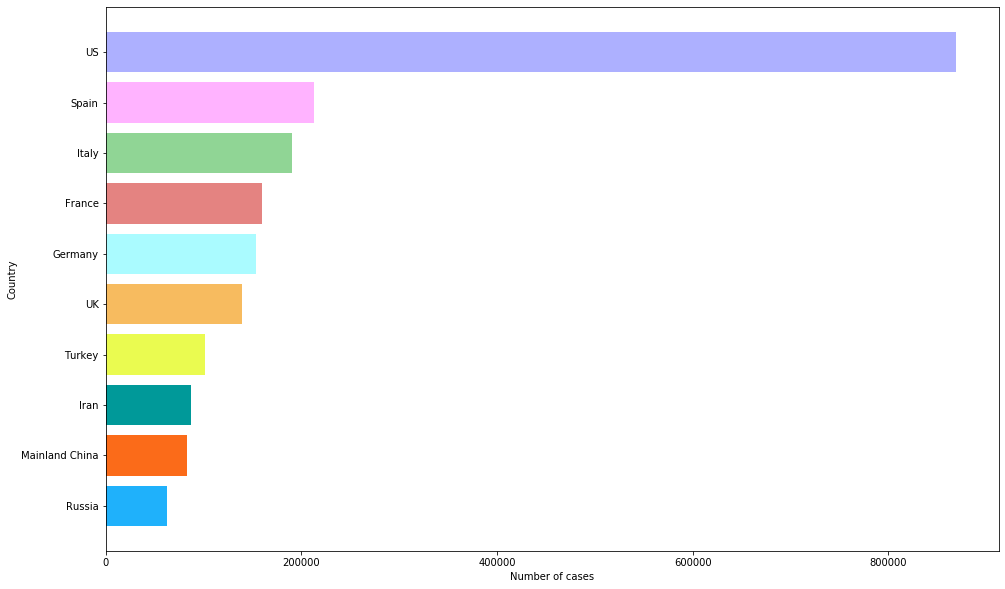

In [48]:
top_10_affected = top_10_affected[::-1]
fig,ax = plt.subplots(figsize=(16,10))
ax.barh(top_10_affected.index,top_10_affected['Confirmed'],color=[colors[x] for x in top_10_affected.index])
plt.xlabel('Number of cases')
plt.ylabel('Country')

For every bar, we also need to display the information of the `Confirmed` cases.

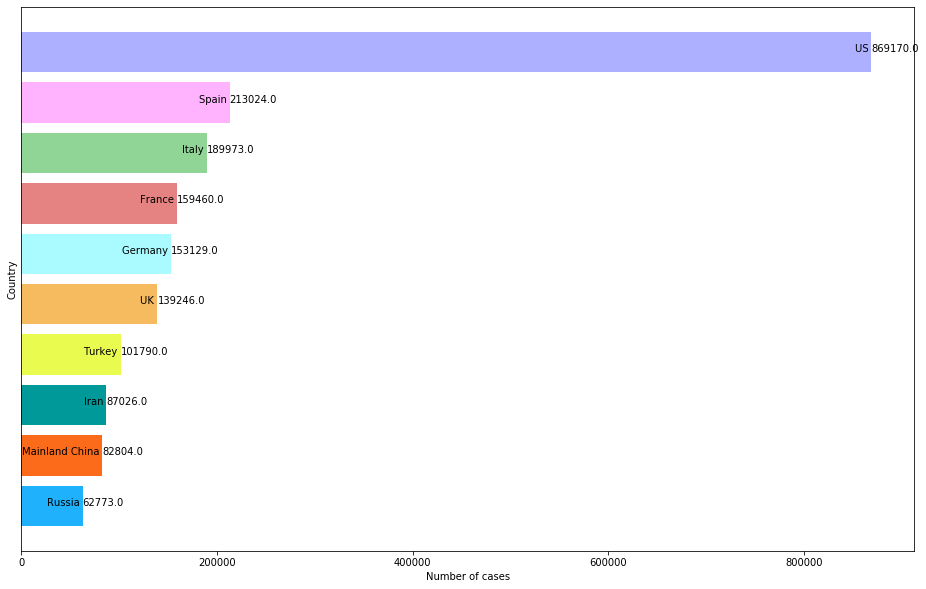

In [49]:
fig,ax = plt.subplots(figsize=(16,10))
ax.barh(top_10_affected.index,top_10_affected['Confirmed'],color=[colors[x] for x in top_10_affected.index])
plt.xlabel('Number of cases')
plt.ylabel('Country')
plt.yticks([])
for i,(cases,country) in enumerate(zip(top_10_affected.Confirmed,top_10_affected.index)):
    ax.text(cases,i,country+" ",ha='right')
    ax.text(cases,i,cases,ha='left')

This looks like a good starter plot, now to animate this over time, we first need a function that will create a barplot similar to the above for every frame (date). This function will be later used and called repeatedly for each frame. Before we go there, we will have to create a mapping for each unique country to a color.

In [50]:
colors = dict(zip(
    df_date_series.Country.unique(),
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#f7bb5f','#fb6b19','#1fb1fb'] * 31
))
colors

{'Japan': '#adb0ff',
 'Macau': '#ffb3ff',
 'Mainland China': '#90d595',
 'South Korea': '#e48381',
 'Taiwan': '#f7bb5f',
 'Thailand': '#fb6b19',
 'US': '#1fb1fb',
 'Hong Kong': '#adb0ff',
 'Singapore': '#ffb3ff',
 'Vietnam': '#90d595',
 'France': '#e48381',
 'Australia': '#f7bb5f',
 'Malaysia': '#fb6b19',
 'Nepal': '#1fb1fb',
 'Canada': '#adb0ff',
 'Cambodia': '#ffb3ff',
 'Ivory Coast': '#90d595',
 'Sri Lanka': '#e48381',
 'Germany': '#f7bb5f',
 'Finland': '#fb6b19',
 'United Arab Emirates': '#1fb1fb',
 'India': '#adb0ff',
 'Philippines': '#ffb3ff',
 'Italy': '#90d595',
 'Russia': '#e48381',
 'Sweden': '#f7bb5f',
 'UK': '#fb6b19',
 'Spain': '#1fb1fb',
 'Belgium': '#adb0ff',
 'Others': '#ffb3ff',
 'Egypt': '#90d595',
 'Iran': '#e48381',
 'Israel': '#f7bb5f',
 'Lebanon': '#fb6b19',
 'Afghanistan': '#1fb1fb',
 'Bahrain': '#adb0ff',
 'Iraq': '#ffb3ff',
 'Kuwait': '#90d595',
 'Oman': '#e48381',
 'Algeria': '#f7bb5f',
 'Austria': '#fb6b19',
 'Croatia': '#1fb1fb',
 'Switzerland': '#adb0ff',
 

In [51]:
def plot_barh(date):
    data = df_date_series[df_date_series.Date.eq(date)].sort_values(
        'Confirmed',
        ascending=False
    ).head(10) #Taking top 10 most countries with cases for each date
    data = data[::-1] #Reversing it, so we have highest value on top
    
    ax.clear() #Clear all axes before proceeding, as same subplot used for every frame
    
    ax.barh( #Making the horizontal bar plot for 10 countries of a particular date
        data.Country,
        data.Confirmed,
        color= [colors[c] for c in data.Country]
    )
    
    max_val = data.Confirmed.max() #At any given time, the right bound of the x-axis
    tot_bars = len(data)
    
    for i,(cases,country,deaths) in enumerate(zip(data.Confirmed,data.Country,data.Deaths)):
        ax.text(cases,i,country+" ",ha='right') #Adding Country informations
        ax.text(cases,i-0.15,deaths,ha='left') #Adding Death count
        ax.text(cases,i+0.15,cases,ha='left') #Adding Confirmed cases count
    
    
    ax.set_yticks([])
    ax.set_xticks([])
    
    ax.set_title('Number of COVID-19 cases per counntry',fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.text(max_val,tot_bars/2,date,fontsize=16) #Displaying date for which this frame is create
    
#plt.box(False)

Now that we have out function ready, we are going to give it to the `matplotlib.animation` module with the frames as `Date` to build the animation for us.

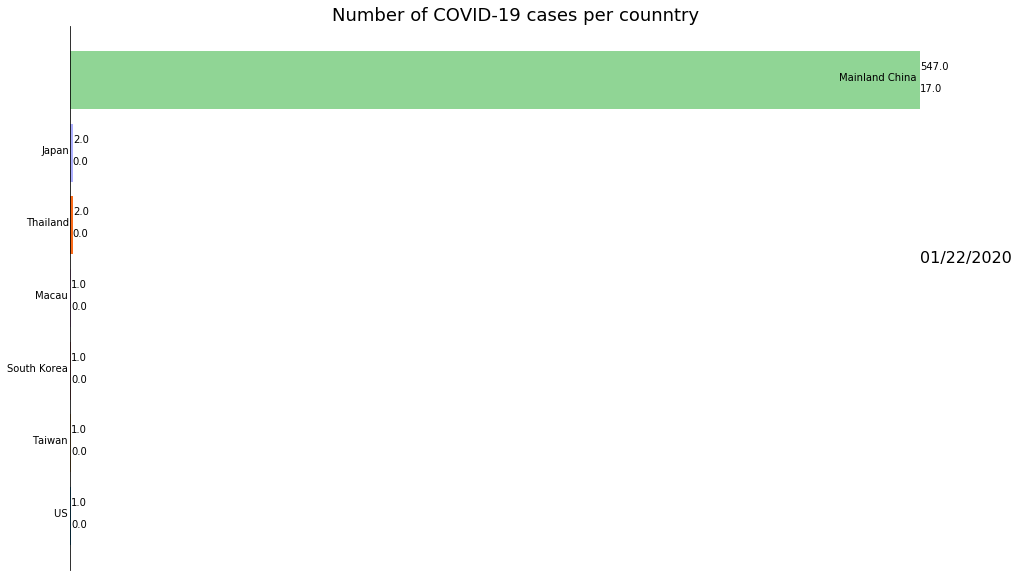

In [52]:
fig,ax = plt.subplots(figsize=(16,10)) #Set figure for plot
animator = animate.FuncAnimation(fig,plot_barh,frames=df_date_series.Date.unique()) #Building animation
HTML(animator.to_jshtml()) #Displaying animation in JsHTML format

The racing bar plot gives a good head to head count of number of cases and deaths.

This concludes the project of Visualizing COVID-19 Spread.